In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import Bunch
from sklearn.datasets import load_breast_cancer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [41]:
# Define column names as per UCI Heart Disease dataset
column_names = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
    "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"
]

# Load the data from the UCI repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart_df = pd.read_csv(url, names=column_names)

# Handle missing values
heart_df.replace('?', np.nan, inplace=True)
heart_df.dropna(inplace=True)

# Convert all values to float
heart_df = heart_df.astype(float)

# Separate features and target
data = heart_df.drop("target", axis=1).values
target = heart_df["target"].values

# Subcluster sizes
subcluster_sizes = [2, 3, 4]

Perform three clustering algos Kmeans, Agglomerative, DBSCAN

In [15]:
# Define clustering algorithms
clustering_algorithms = {
    'KMeans': KMeans,
    'AgglomerativeClustering': AgglomerativeClustering,
    'DBSCAN': DBSCAN
}

In [17]:
# Initialize dictionaries to store results for each algorithm
results_dict = {algorithm_name: [] for algorithm_name in clustering_algorithms.keys()}

In [19]:
import warnings
# Ignore specific warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows with MKL")
warnings.filterwarnings("ignore", message="The default value of `n_init` will change from 10 to 'auto' in 1.4.")

In [21]:
# Loop through different clustering algorithms
for algorithm_name, algorithm in clustering_algorithms.items():
    # Loop through different data processing methods
    for processing_method in ['No Data Processing', 'Normalization', 'Transformation', 'PCA', 'T+N', 'T+N+PCA']:
        for subcluster_size in subcluster_sizes:
            # Apply data processing based on the method
            processed_data = data.copy()  # Assume no processing by default
            if processing_method == 'Normalization':
                scaler = MinMaxScaler()
                processed_data = scaler.fit_transform(data)
            elif processing_method == 'Transformation':
                scaler = StandardScaler()
                processed_data = scaler.fit_transform(data)
            elif processing_method == 'PCA':
                pca = PCA(n_components=min(subcluster_size, data.shape[1]))
                processed_data = pca.fit_transform(data)
            elif processing_method == 'T+N':
                scaler = MinMaxScaler()
                transformed_data = scaler.fit_transform(data)
                processed_data = transformed_data
            elif processing_method == 'T+N+PCA':
                scaler = MinMaxScaler()
                transformed_data = scaler.fit_transform(data)
                pca = PCA(n_components=min(subcluster_size, data.shape[1]))
                processed_data = pca.fit_transform(transformed_data)
            
            # Perform clustering
            if algorithm_name == 'DBSCAN':
                clusters = algorithm(eps=0.5, min_samples=5).fit_predict(processed_data)
            else:
                clusters = algorithm(n_clusters=subcluster_size).fit_predict(processed_data)
            
            # Check if clustering generated valid clusters
            unique_labels = len(set(clusters))
            if unique_labels > 1:
                # Calculate evaluation metrics
                silhouette = silhouette_score(processed_data, clusters)
                calinski_harabasz = calinski_harabasz_score(processed_data, clusters)
                davies_bouldin = davies_bouldin_score(processed_data, clusters)
                
                # Append results to the list
                results_dict[algorithm_name].append({
                    'Algorithm': algorithm_name,
                    'Processing Method': processing_method,
                    'Subcluster Size': subcluster_size,
                    'Silhouette Score': silhouette,
                    'Calinski-Harabasz Score': calinski_harabasz,
                    'Davies-Bouldin Score': davies_bouldin
                })

In [23]:
# Create DataFrames for each algorithm
dfs = {}
for algorithm_name, results in results_dict.items():
    dfs[algorithm_name] = pd.DataFrame(results)

# Print the results in a beautiful table format
for algorithm_name, df in dfs.items():
    print(f"Clustering Algorithm: {algorithm_name}\n")
    print(df.to_string(index=False))
    print("\n\n")

Clustering Algorithm: KMeans

Algorithm  Processing Method  Subcluster Size  Silhouette Score  Calinski-Harabasz Score  Davies-Bouldin Score
   KMeans No Data Processing                2          0.385793               235.146181              0.973060
   KMeans No Data Processing                3          0.284067               191.233644              1.146550
   KMeans No Data Processing                4          0.280847               160.468985              0.916101
   KMeans      Normalization                2          0.166143                28.495220              2.255240
   KMeans      Normalization                3          0.193086                65.154709              1.811467
   KMeans      Normalization                4          0.189049                53.896916              1.839711
   KMeans     Transformation                2          0.175114                61.665647              2.079236
   KMeans     Transformation                3          0.128788                46.

In [25]:
# Save results as CSV files
for algorithm_name, df in dfs.items():
    filename = f"{algorithm_name}_results.csv"
    df.T.to_csv(filename)
    print(f"{filename} saved successfully.\n")

KMeans_results.csv saved successfully.

AgglomerativeClustering_results.csv saved successfully.

DBSCAN_results.csv saved successfully.



In [27]:
## Plotting the findings

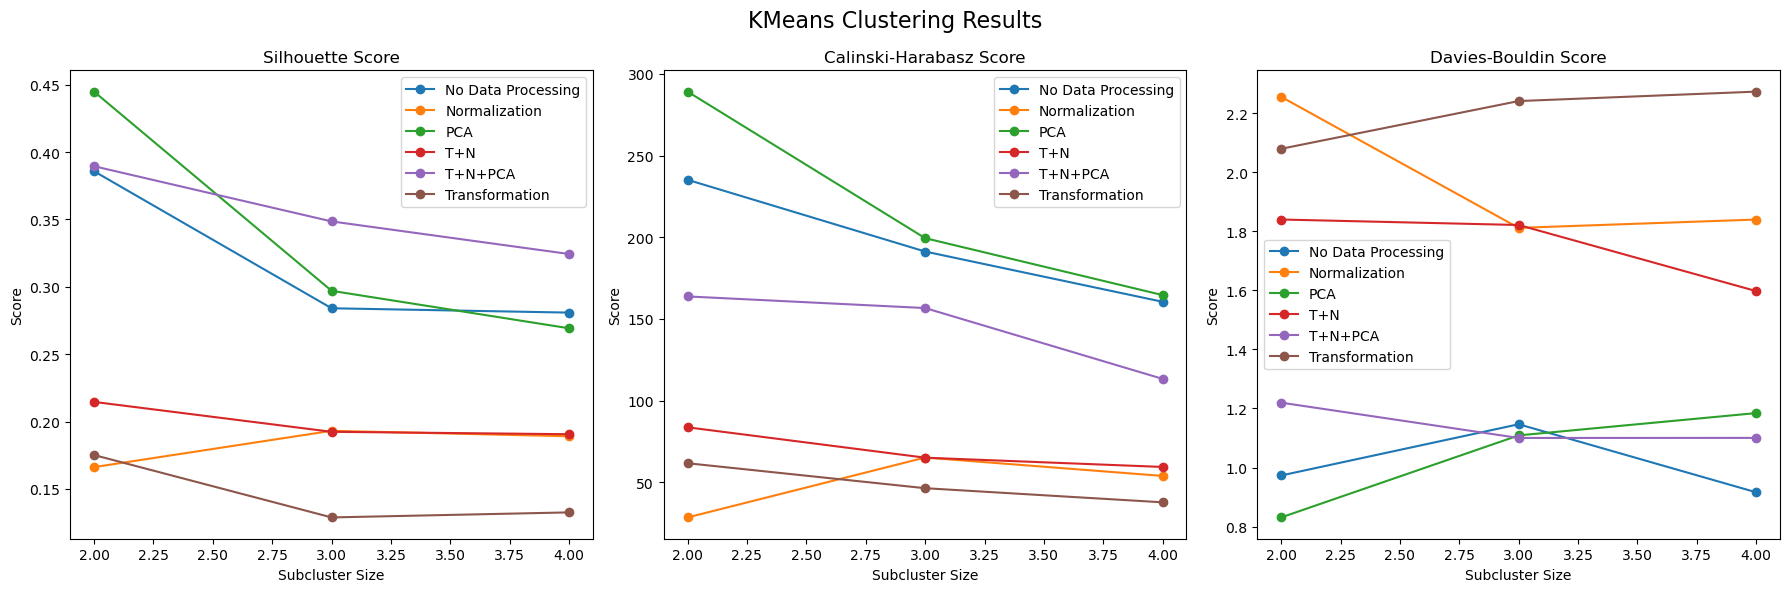

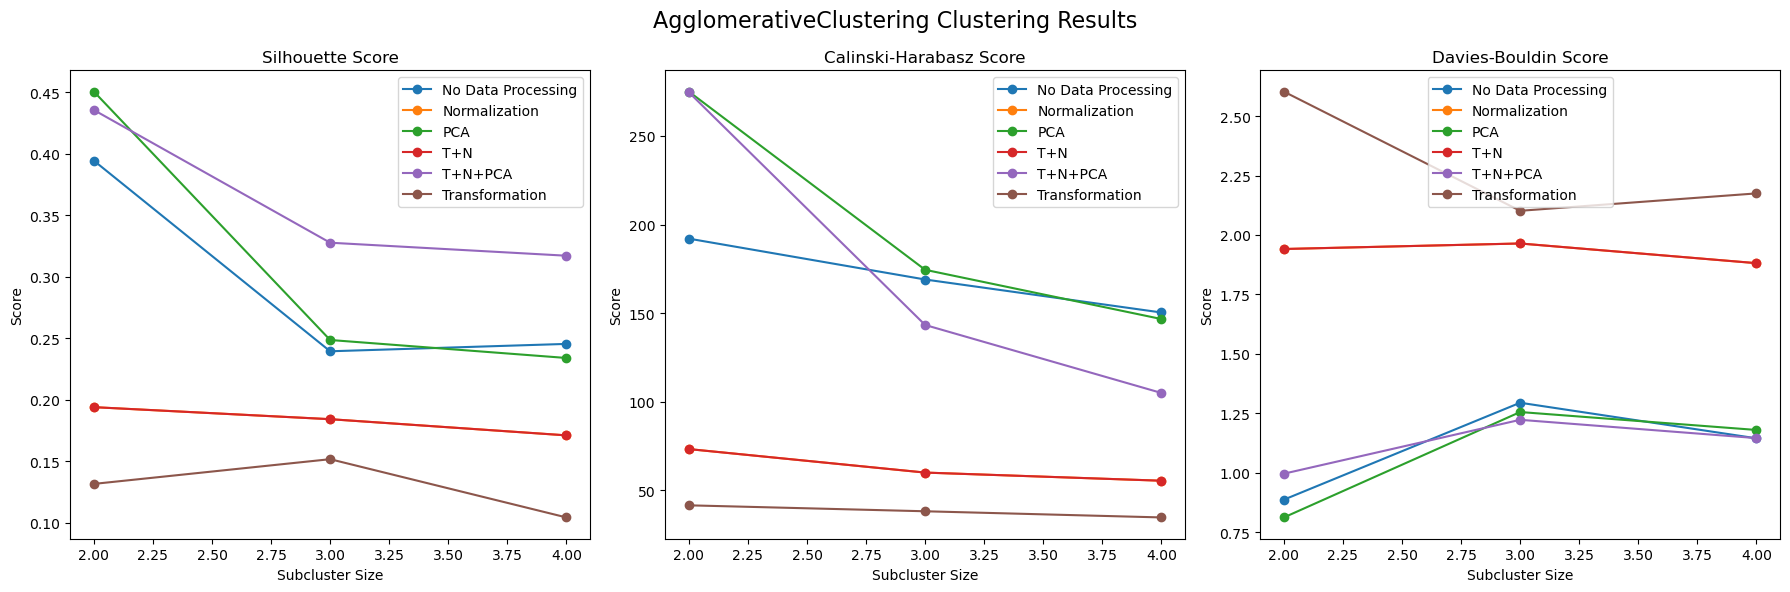

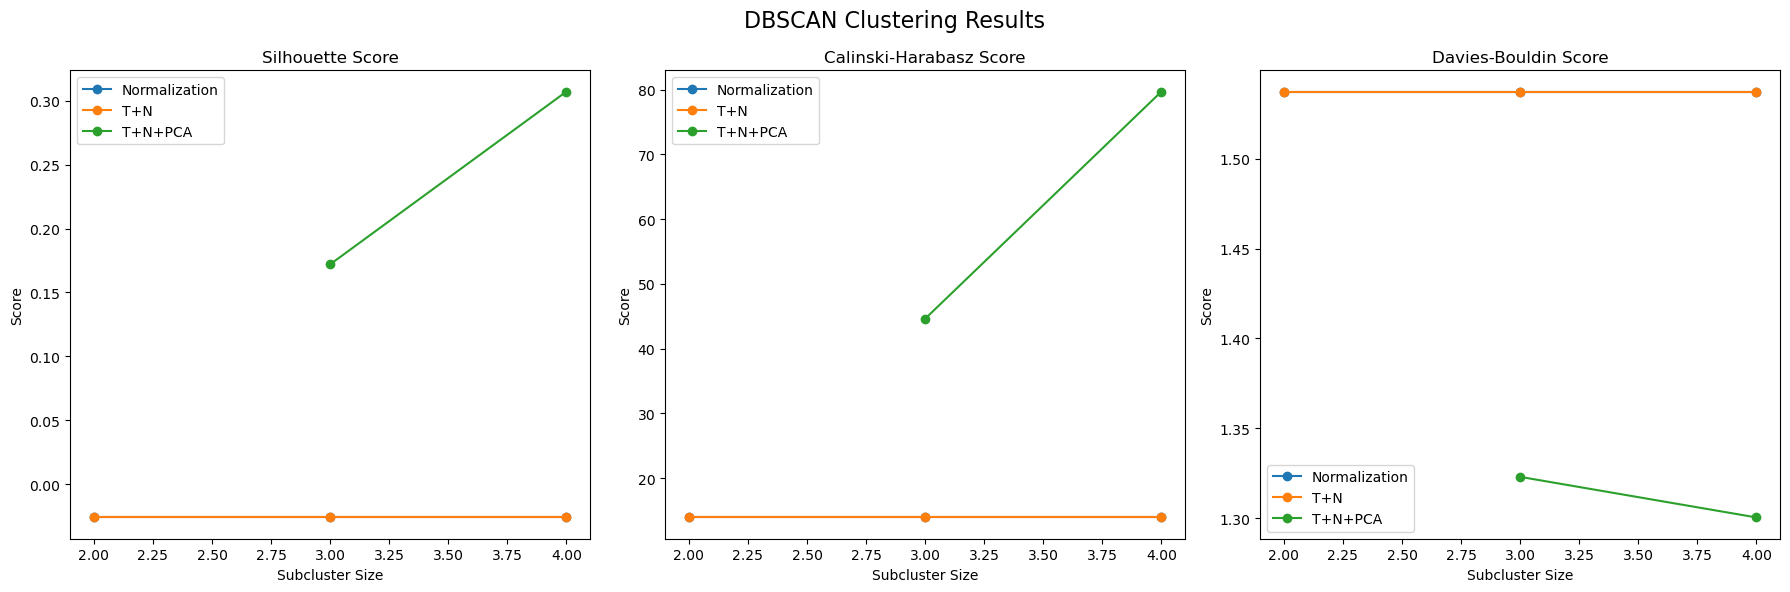

In [45]:
# Define function to plot graphs for each clustering algorithm
def plot_results_per_algorithm(algorithm_name, df):
    # Create subplots for each metric
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Plot each metric
    for i, metric in enumerate(['Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score']):
        ax = axs[i]
        for method, method_df in df.groupby('Processing Method'):
            ax.plot(method_df['Subcluster Size'], method_df[metric], marker='o', label=method)
        ax.set_title(metric)
        ax.set_xlabel('Subcluster Size')
        ax.set_ylabel('Score')
        ax.legend()

    # Set title for the entire plot
    plt.suptitle(f'{algorithm_name} Clustering Results', fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot results for each algorithm
for algorithm_name, df in dfs.items():
    plot_results_per_algorithm(algorithm_name, df)

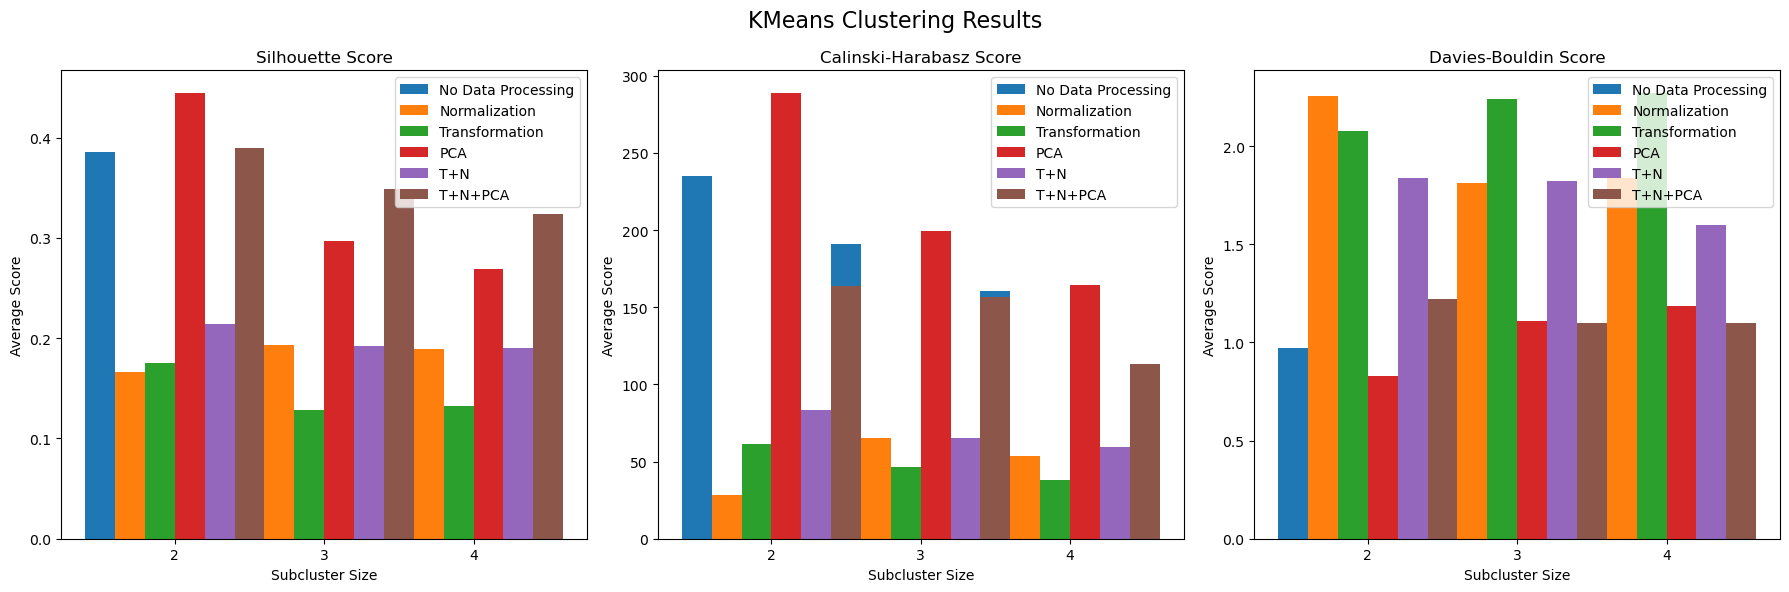

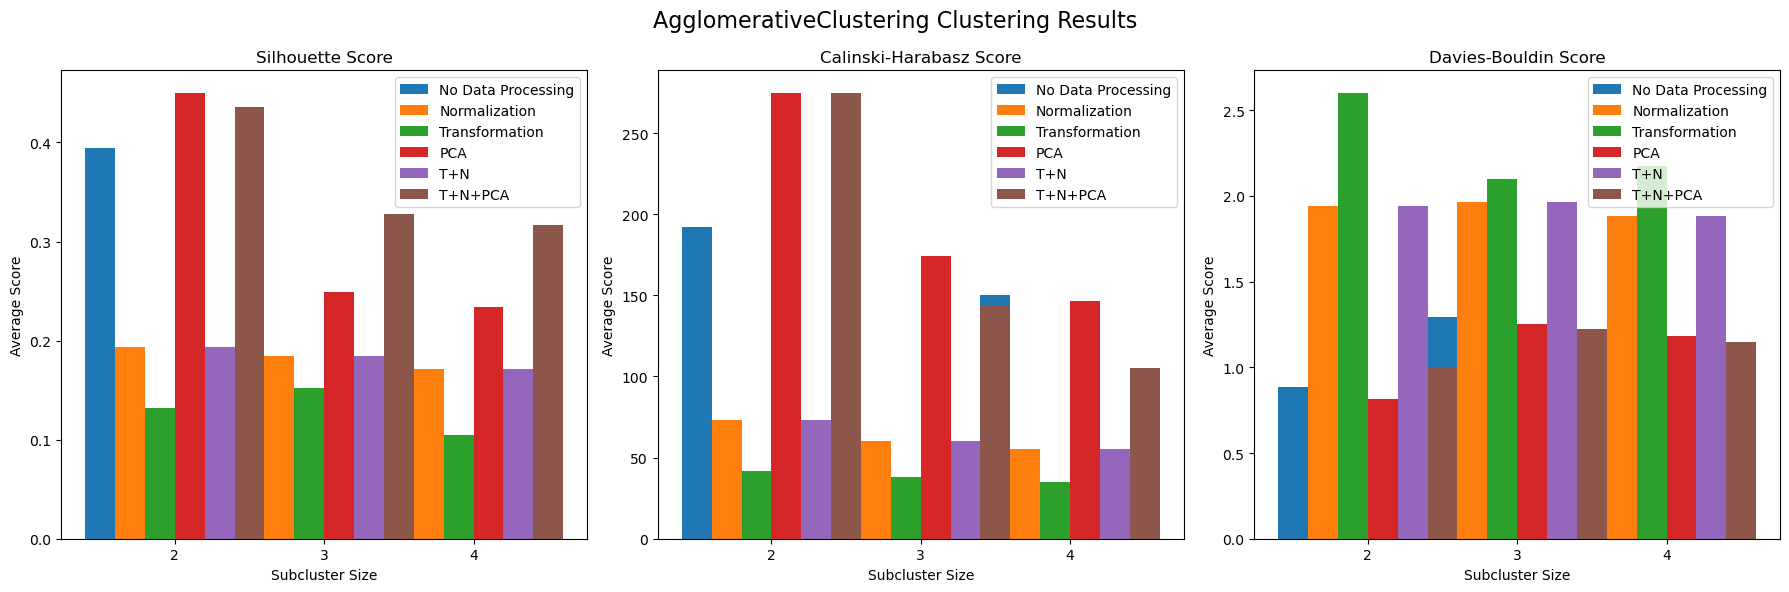

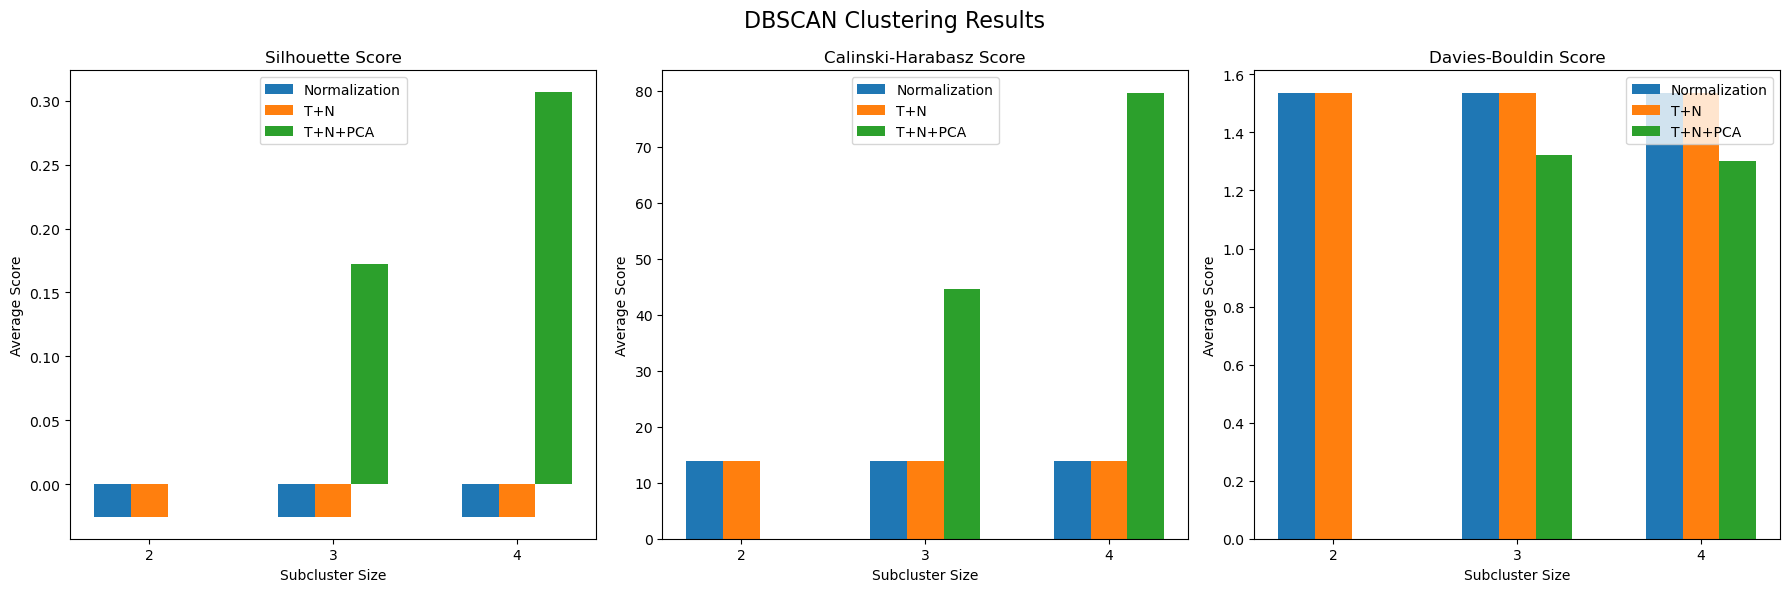

In [49]:
import numpy as np

# Define function to plot bar graphs for each clustering algorithm
def plot_bar_results_per_algorithm(algorithm_name, df):
    # Get unique processing methods and subcluster sizes
    processing_methods = df['Processing Method'].unique()
    subcluster_sizes = df['Subcluster Size'].unique()

    # Create subplots for each metric
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Plot bar graphs for each metric
    for i, metric in enumerate(['Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score']):
        ax = axs[i]
        bar_width = 0.2
        for j, method in enumerate(processing_methods):
            scores = []
            for size in subcluster_sizes:
                size_df = df[(df['Processing Method'] == method) & (df['Subcluster Size'] == size)]
                scores.append(size_df[metric].mean())
            ax.bar(np.arange(len(subcluster_sizes)) + j * bar_width, scores, bar_width, label=method)

        ax.set_title(metric)
        ax.set_xlabel('Subcluster Size')
        ax.set_ylabel('Average Score')
        ax.set_xticks(np.arange(len(subcluster_sizes)) + bar_width * (len(processing_methods) - 1) / 2)
        ax.set_xticklabels(subcluster_sizes)
        ax.legend()

    # Set title for the entire plot
    plt.suptitle(f'{algorithm_name} Clustering Results', fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot bar results for each algorithm
for algorithm_name, df in dfs.items():
    plot_bar_results_per_algorithm(algorithm_name, df)
